# Deep Learning Implementation of Language Transliteration

Notebook demonstrates the transliteration of Indic words in to English; currently this model is being trained on Indian Language and get it transliterated into English.

Its bases on character level Sequence to Sequence Recurrent Neural Network(RNN) Encoder Decoder Deep Learning approach and this would be script  independent i.e. output does not depends on linguistic of the script just we have to  give large number of pairs of Local Language Words with corresponding English words and train it character by character to create two RNN network (Encoder and Decoder), currently its being trained on Indian Language to English with character level mapping and it works because for Indian languages there is a character by character mapping with that of English , As this model is based on RNN we could further enhanced this model to extend the support to other foreign languages where one symbol/character corresponds to a word like we have in Korean/Japanese/Chinese.

We publishing the source of this model so that it could be trained on language transliterated pair dataset. Input to the model would be comma separated local language words and English words e.g.

गणेश राजाभाऊ,ganesha rajabhau <br/>
अरुण रंगनाथ,aruna ranganatha


In [1]:
from __future__ import print_function
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
from keras.callbacks import ModelCheckpoint

batch_size = 64  # Batch size for training.
epochs = 10 # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 5000 # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'path/to/dataset.csv'

import os
#User all GPU's
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Using TensorFlow backend.


# Tokenize the input and output text in individual words

In [2]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='UTF-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    try:
        input_text, target_text = line.split(',')
    except: #code to run if error occurs
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
        pass
    for i in range(0,6):
        try:
        
            input_text_m = input_text.split()[i]+ ' '
            input_texts.append(input_text_m)
            target_text_m = '\t' +  target_text.split()[i] + ' ' + '\n'
            target_texts.append(target_text_m)
            
            for char in input_text_m:
                if char not in input_characters:
                    input_characters.add(char)
            for char in target_text_m:
                if char not in target_characters:
                    target_characters.add(char)
        except:
            pass

print (input_texts)
print (target_texts)

['भिमराव ', 'वेणुनाथ ', 'आगळे ', 'हरिचंद्र ', 'वेणुनाथ ', 'आगळे ', 'शिवनारायण ', 'वेणुनाथ ', 'आगळे ', 'लालासाहेब ', 'रामचंद्र ', 'आगळे ', 'सतिष ', 'रामचंद्र ', 'आगळे ', 'दशरथ ', 'बंडा ', 'आगळे ', 'दत्तात्रय ', 'शंकरराव ', 'बरकते ', 'राजाभाऊ ', 'शंकरराव ', 'बरकते ', 'लालासाहेब ', 'दत्तात्रय ', 'बरकते ', 'गणेश ', 'राजाभाऊ ', 'बरकते ', 'लालासाहेब ', 'दत्तात्रय ', 'बरकते ', 'भारत ', 'काशिनाथ ', 'आगळे ', 'पार्वतीबाई ', 'महादेव ', 'आगळे ', 'महेश ', 'श्रीराम ', 'आगळे ', 'राजाभाऊ ', 'शंकरराव ', 'बरकते ', 'बालाजी ', 'धोंडीराम ', 'आगळे ', 'बद्रीनारायण ', 'हरीश्चंद्र ', 'आगळे ', 'बजरंग ', 'हरीश्चंद्र ', 'आगळे ', 'शिवनारायण ', 'वेणुनाथ ', 'आगळे ', 'शिवनारायण ', 'वेणुनाथ ', 'आगळे ', 'दादासाहेब ', 'भगवान ', 'दसवंते ', 'बालासाहेब ', 'बाबुराव ', 'आगळे ', 'शंकुतला ', 'जीवन ', 'दसवंते ', 'विश्वनाथ ', 'किसन ', 'दसवंते ', 'धोंडीराम ', 'हरीभाऊ ', 'आगळे ', 'अर्चना ', 'मारुती ', 'अंधारे ', 'स्वप्निल ', 'मारुती ', 'अंधारे ', 'ओमप्रकाश ', 'चत्रभुज ', 'आगळे ', 'बळीराम ', 'चत्रभुज ', 'आगळे ', 'उषा ', 'लहुदास ', 

# Identify the number of input and output tokens at character level
These token are fetched out based on the input data provided whcih is less than we actually have in language, if we have exceesive data provided then it should all the chaacyters of correspoding script

In [3]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

#max_encoder_seq_length =100
#max_decoder_seq_length =100
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens,input_characters)
print('Number of unique output tokens:', num_decoder_tokens,target_characters)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)




Number of samples: 15509
Number of unique input tokens: 75 [' ', '(', ')', '-', '.', '/', '0', '1', '2', '3', '4', '6', 'ँ', 'ं', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऑ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ऱ', 'ल', 'ळ', 'व', 'श', 'ष', 'स', 'ह', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॅ', 'े', 'ै', 'ॉ', 'ो', 'ौ', '्', 'क़', '३', '\u200d']
Number of unique output tokens: 42 ['\t', '\n', ' ', '"', '(', ')', '-', '.', '/', '0', '1', '2', '3', '4', '6', 'a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', 'ऑ', 'ऱ', 'ॅ', 'ॉ', 'क़', '\u200d']
Max sequence length for inputs: 23
Max sequence length for outputs: 30


# Indexing the characters
Here we are indexing all the characters at source as well as target text and creating a placeholders for 
encoder_input_data, decoder_input_data and decoder_target_data matrices


In [4]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
print(input_token_index)

target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])
print(target_token_index)

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')

decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')



{' ': 0, '(': 1, ')': 2, '-': 3, '.': 4, '/': 5, '0': 6, '1': 7, '2': 8, '3': 9, '4': 10, '6': 11, 'ँ': 12, 'ं': 13, 'अ': 14, 'आ': 15, 'इ': 16, 'ई': 17, 'उ': 18, 'ऊ': 19, 'ऋ': 20, 'ए': 21, 'ऑ': 22, 'ओ': 23, 'औ': 24, 'क': 25, 'ख': 26, 'ग': 27, 'घ': 28, 'च': 29, 'छ': 30, 'ज': 31, 'झ': 32, 'ञ': 33, 'ट': 34, 'ठ': 35, 'ड': 36, 'ढ': 37, 'ण': 38, 'त': 39, 'थ': 40, 'द': 41, 'ध': 42, 'न': 43, 'प': 44, 'फ': 45, 'ब': 46, 'भ': 47, 'म': 48, 'य': 49, 'र': 50, 'ऱ': 51, 'ल': 52, 'ळ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ा': 59, 'ि': 60, 'ी': 61, 'ु': 62, 'ू': 63, 'ृ': 64, 'ॅ': 65, 'े': 66, 'ै': 67, 'ॉ': 68, 'ो': 69, 'ौ': 70, '्': 71, 'क़': 72, '३': 73, '\u200d': 74}
{'\t': 0, '\n': 1, ' ': 2, '"': 3, '(': 4, ')': 5, '-': 6, '.': 7, '/': 8, '0': 9, '1': 10, '2': 11, '3': 12, '4': 13, '6': 14, 'a': 15, 'b': 16, 'c': 17, 'd': 18, 'e': 19, 'g': 20, 'h': 21, 'i': 22, 'j': 23, 'k': 24, 'l': 25, 'm': 26, 'n': 27, 'o': 28, 'p': 29, 'r': 30, 's': 31, 't': 32, 'u': 33, 'v': 34, 'y': 35, 'ऑ': 36, 'ऱ'

# Creating Recurrent Neural Network
Creating Recurrent Neural Network with Encoder and Decoder Architecture using LSTM cell and one layer.

In [5]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)



# Network Training
Trainin the RNN with below configurations
### optimizer: 
rmsprop  
### loss function: 
categorical_crossentropy
### metrics: 
accuracy
### monitorng: 
loss
### vlaidation split: 
0.2

In [6]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

filepath = "s2shin.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, mode='min')
callbacks_list = [checkpoint]

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,callbacks=callbacks_list)

W1023 16:39:36.088921 16720 deprecation.py:323] From C:\Users\moharsha\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1023 16:39:37.563521 16720 deprecation_wrapper.py:119] From C:\Users\moharsha\.conda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 12407 samples, validate on 3102 samples
Epoch 1/10
12407/12407 [==============================] - 62s 5ms/step - loss: 0.7997 - accuracy: 0.7848 - val_loss: 0.6892 - val_accuracy: 0.8217

Epoch 00001: saving model to s2shin.h5
Epoch 2/10
12407/12407 [==============================] - 62s 5ms/step - loss: 0.5263 - accuracy: 0.8521 - val_loss: 0.5175 - val_accuracy: 0.8526

Epoch 00002: saving model to s2shin.h5
Epoch 3/10
12407/12407 [==============================] - 62s 5ms/step - loss: 0.3667 - accuracy: 0.8916 - val_loss: 0.4174 - val_accuracy: 0.8798

Epoch 00003: saving model to s2shin.h5
Epoch 4/10
12407/12407 [==============================] - 61s 5ms/step - loss: 0.2604 - accuracy: 0.9250 - val_loss: 0.3710 - val_accuracy: 0.9021

Epoch 00004: saving model to s2shin.h5
Epoch 5/10
12407/12407 [==============================] - 66s 5ms/step - loss: 0.1963 - accuracy: 0.9448 - val_loss: 0.3148 - val_accuracy: 0.9243

Epoch 00005: saving model to s2shin.h5
Epoch 6/10
12407

# Model Accuracy and Model Loss

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


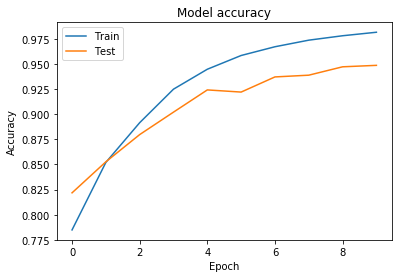

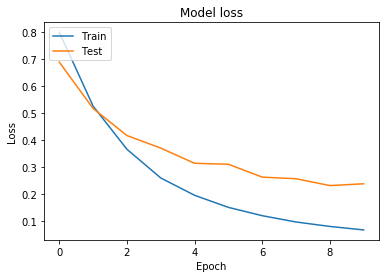

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()